# Illustration of clustering on Velib data

In [169]:
rm(list = ls())

library(funFEM)
library(ggmap)
library(tmaptools)
library(reshape2)

data(velib)

# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

# consider a subsample
set.seed(0)
n <- nrow(x)
stations <- sample(1:n, size = 500)
coord <- velib$position[stations,]

# select exactly 7 days of data
dates <- 14:181
x <- x[stations, dates]  
colnames(x) <- 1:length(dates)

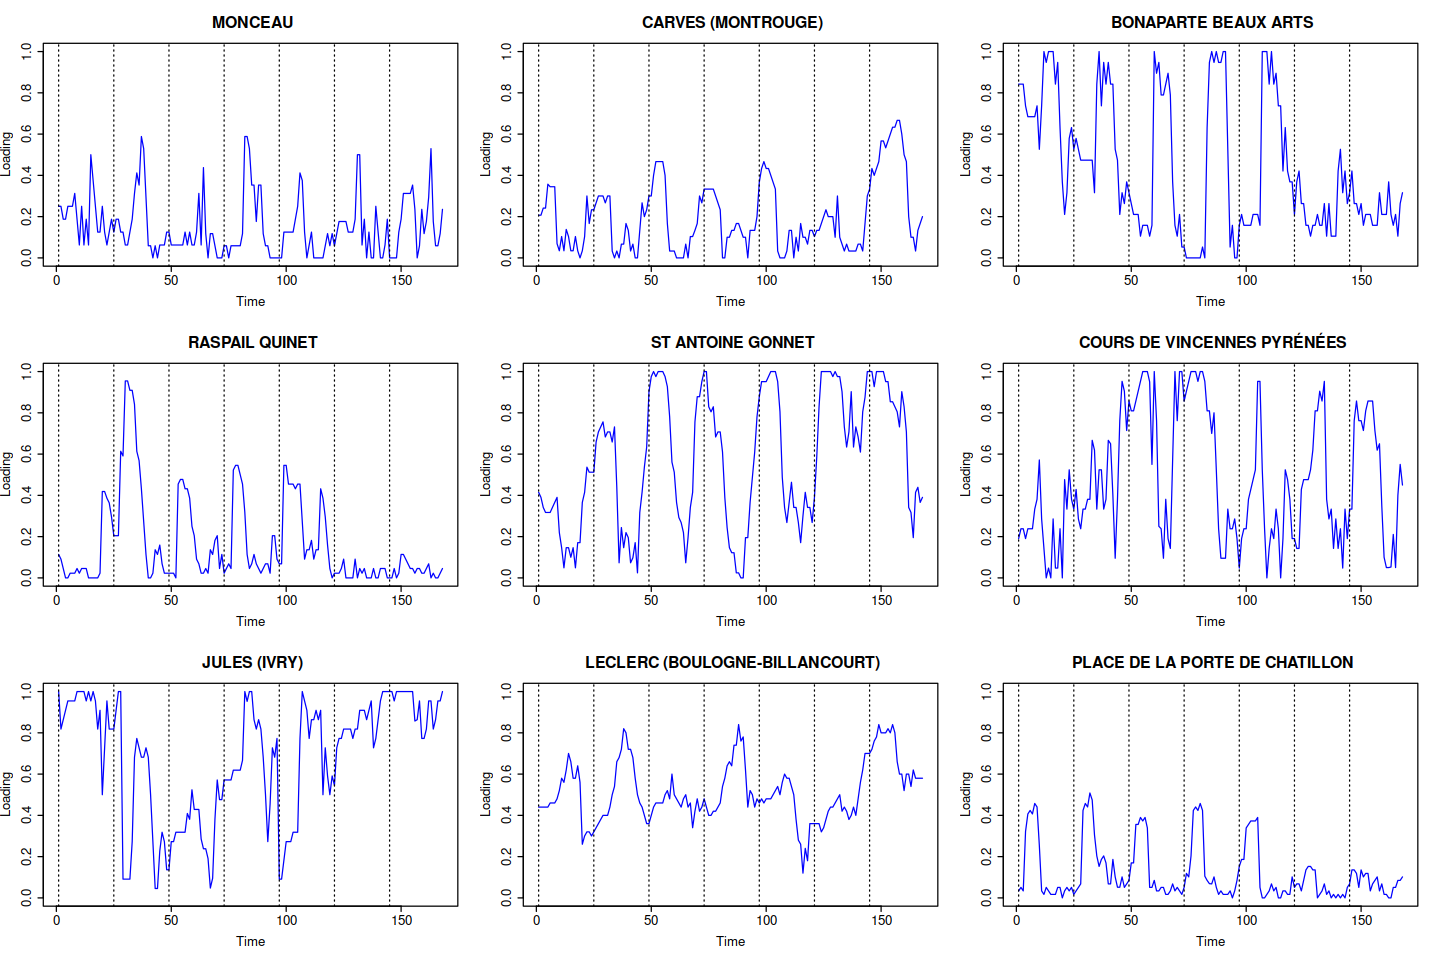

In [170]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=8, repr.plot.res=120)
par(mfrow = c(3, 3))
for (i in 1:9){
  plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = rownames(x)[i])
  abline(v = timeTick, lty = "dotted")
}

In [171]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

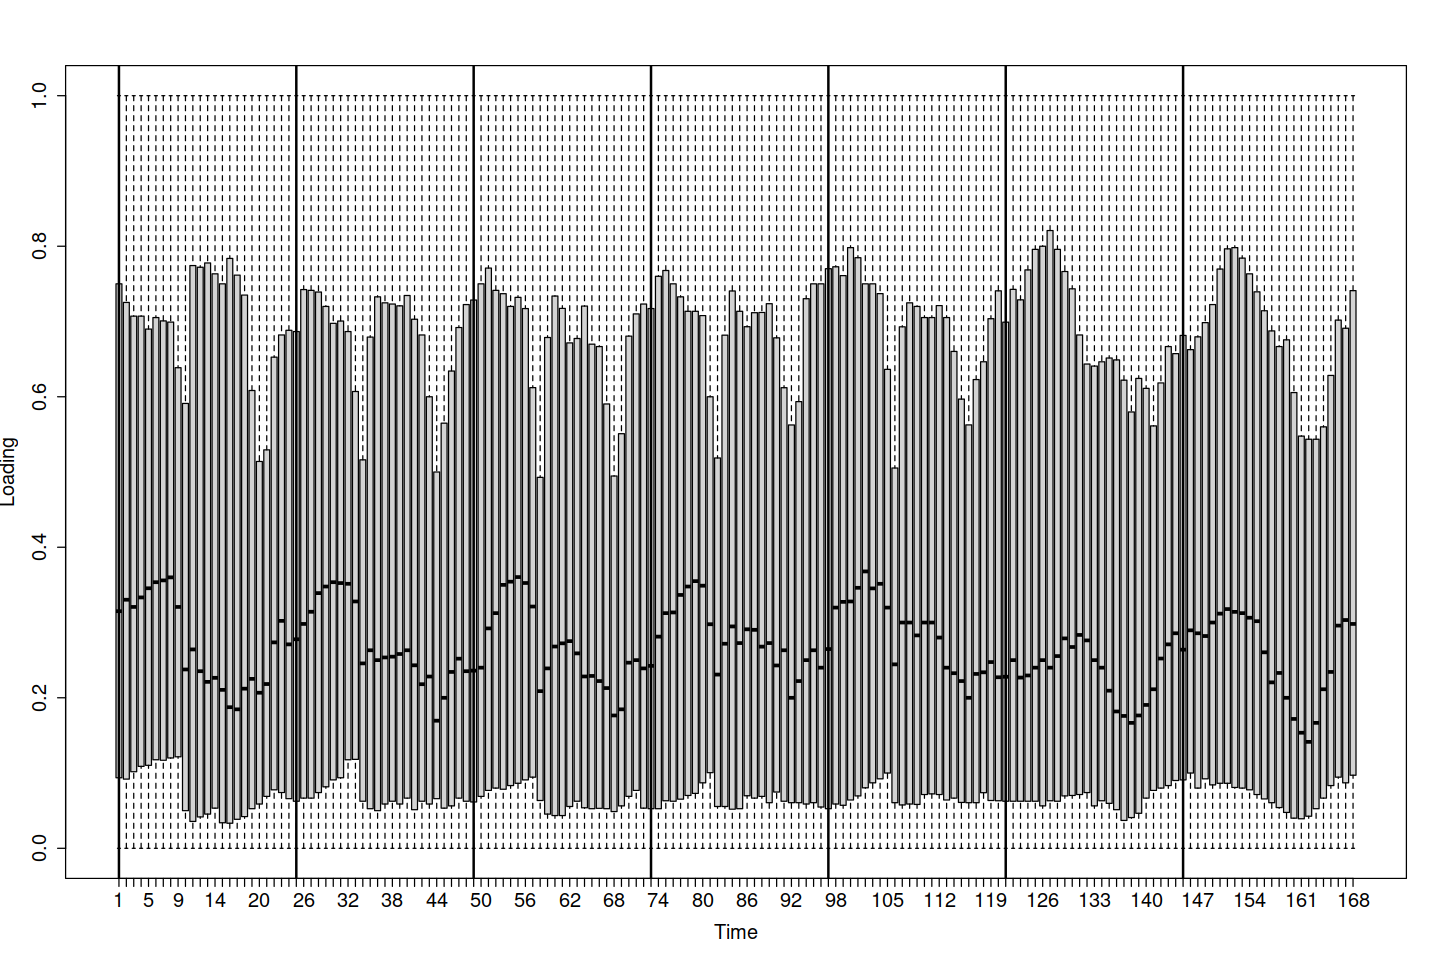

In [172]:
# Boxplot of the variables, sorted in time order
par(mfrow = c(1, 1))
boxplot(x, xlab = "Time", ylab = "Loading")
abline(v = timeTick, lwd = 2)

### Question 1.
Look at the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?

*Les journées de lundi à vendredi sont assez similaires, un pic la nuit et un pic entre midi et deux, ainsi que des périodes de plus faible chargement dans la matinée et en fin d'après-midi (heures d'arrivée et de départ du travail).*

*Le week-end est assez différent de la semaine, avec un retour des vélos dans les stations plus tardif la nuit (pas de travail le lendemain souvent). On ne voit d'ailleurs plus les pics correspondant à l'arrivée et au départ du lieu de travail.*

### Question 2.

a) Perform hierarchical clustering with Ward criterion. 
Plot the dendrogram and the heights versus the number of classes. 
Why choosing 6 classes seems logical?
Do you see another reasonable choice? 

b) What can you say of the sizes of the corresponding classes? 
Are there classes with only one individual? 
This could happen with another criterion: which one? Try it.

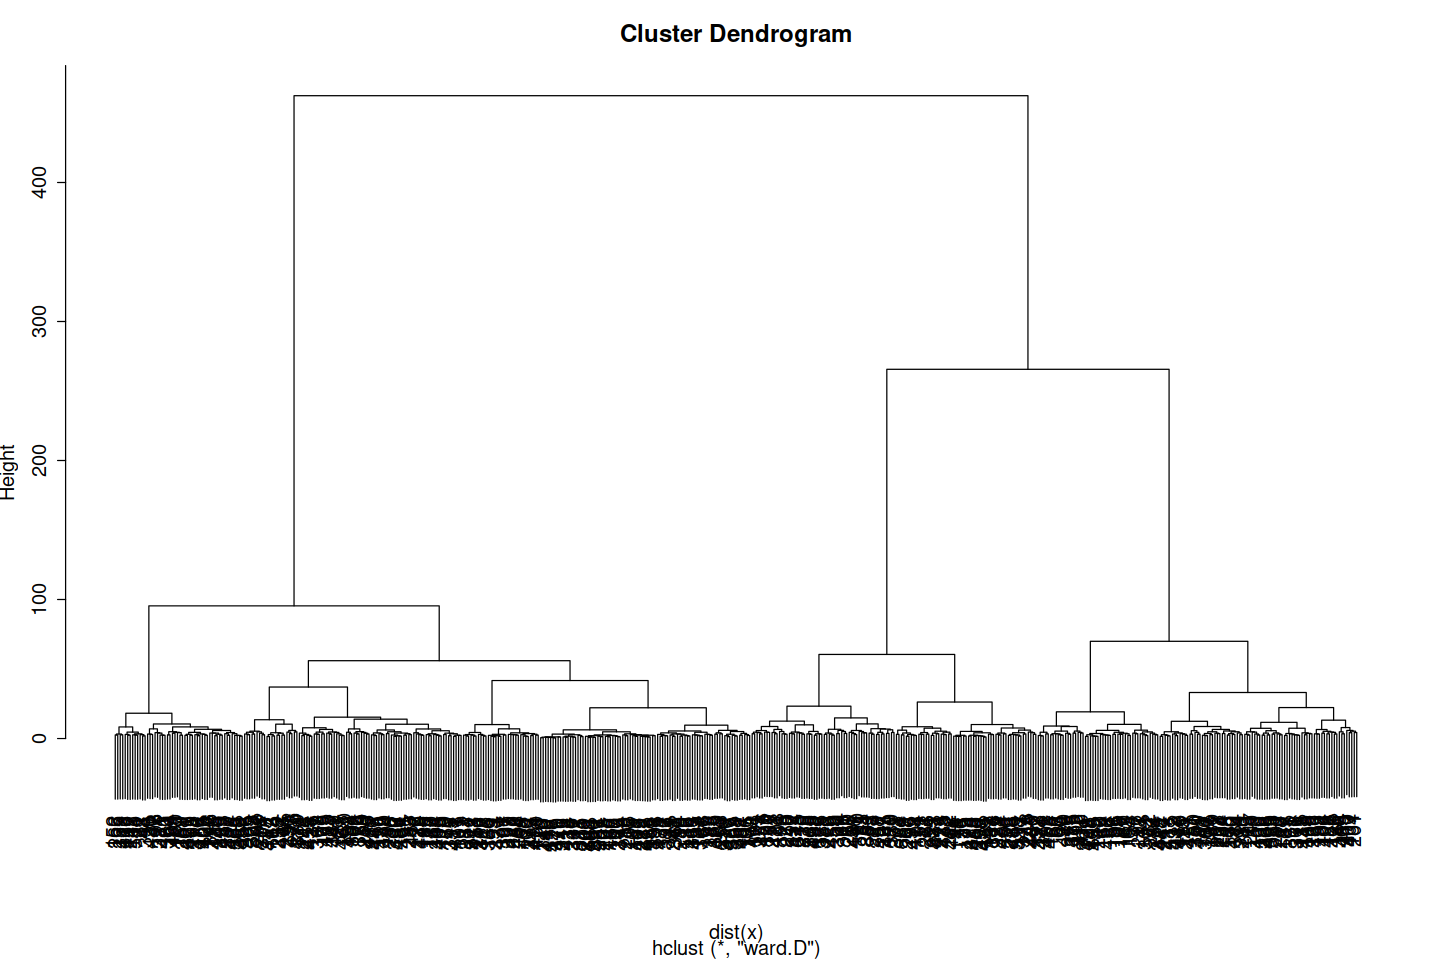

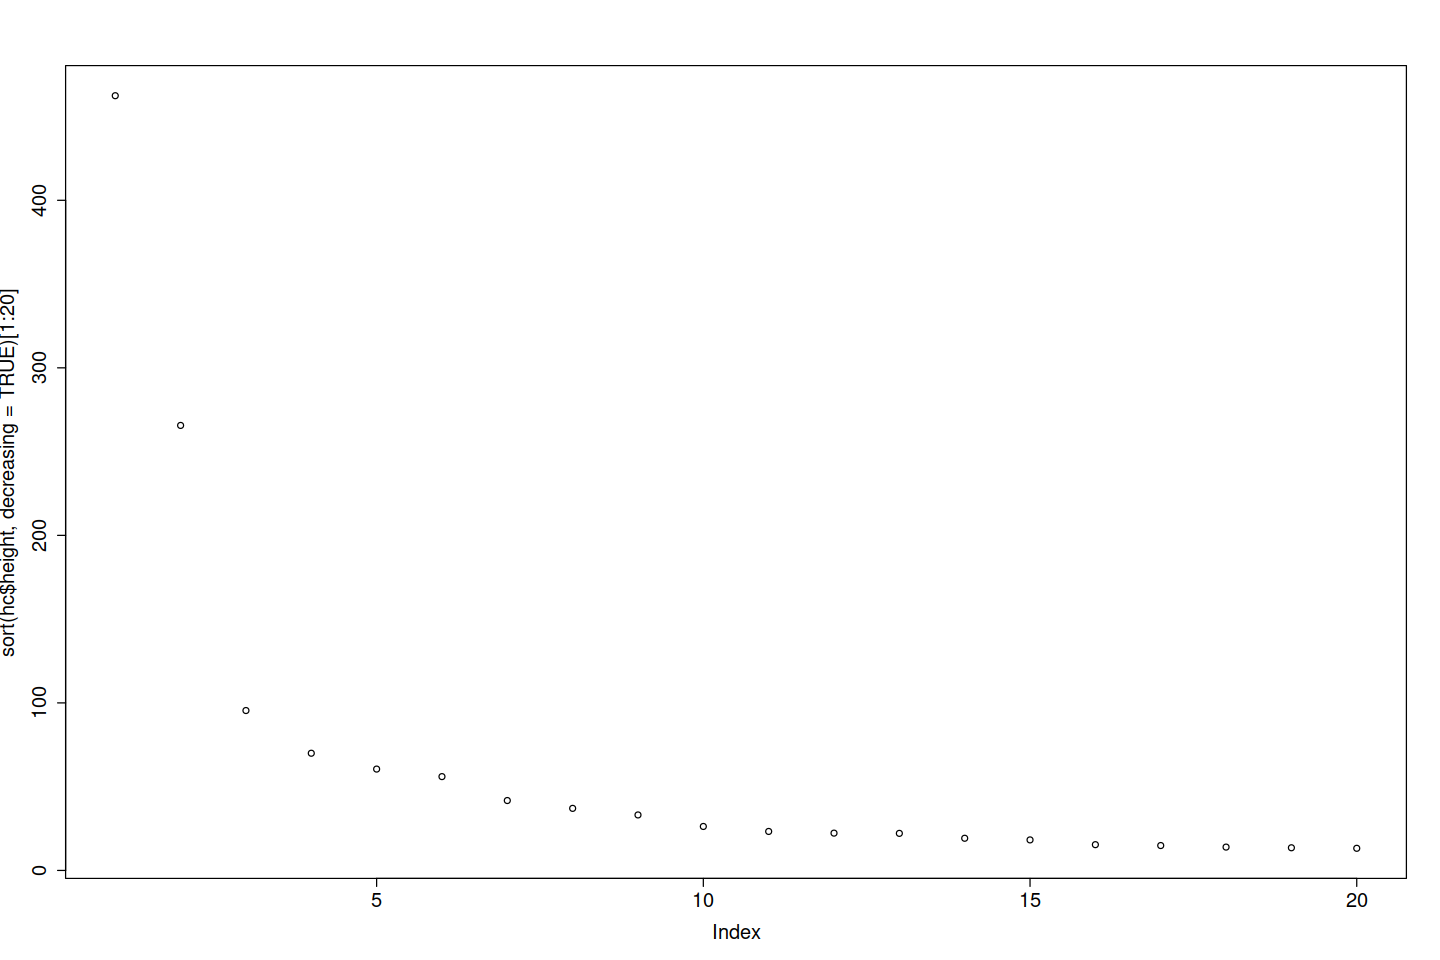

In [173]:
hc = hclust(dist(x), method = "ward.D")
plot(hc)
plot(sort(hc$height, decreasing = TRUE)[1:20])

*a. On choisit 6 classes car sur le graphique des hauteurs en fonction du nombre de classe on voit qu'à partir de 6 classes différentes, les sauts dans l'inertie sont beauoup plus faibles que ceux entre 1 et 6 classes.*

*Nous aurions aussi pu choisir 4 classes différentes, ce qui aurait fonctionné aussi, mais nos classes auraient été plus hétérogènes.*

In [174]:
class = cutree(hc, k = 6)
table(class)
table(cutree(hclust(dist(x), method = "single"), k=6))

class
  1   2   3   4   5   6 
204  58  80  49  57  52 


  1   2   3   4   5   6 
494   1   1   1   2   1 

*Nous n'avons pas de classes quasiement vides, ce qui est une bonne chose.*

*Avec la méthode "single" nous obtenons plusieurs classes d'une taille de 1.*

### Question 3.
Perform k-means with K = 6 classes.

(a) Represent the center of each class as a discrete curve. 
Give the interpretation of the center of class 1 
(remember that vertical straight lines are separations between days, 
from Monday to Sunday). Same question with class 5.

(b) Which criterion aims at minimizing k-means? Is the optimum found local or global?

(c) In order to visualize the quality of the clustering, 
represent the boxplots of loading profiles for each time step, and for each class. 
Are the classes homogeneous? Interpret the results in terms 
of within-class variance and global variance.


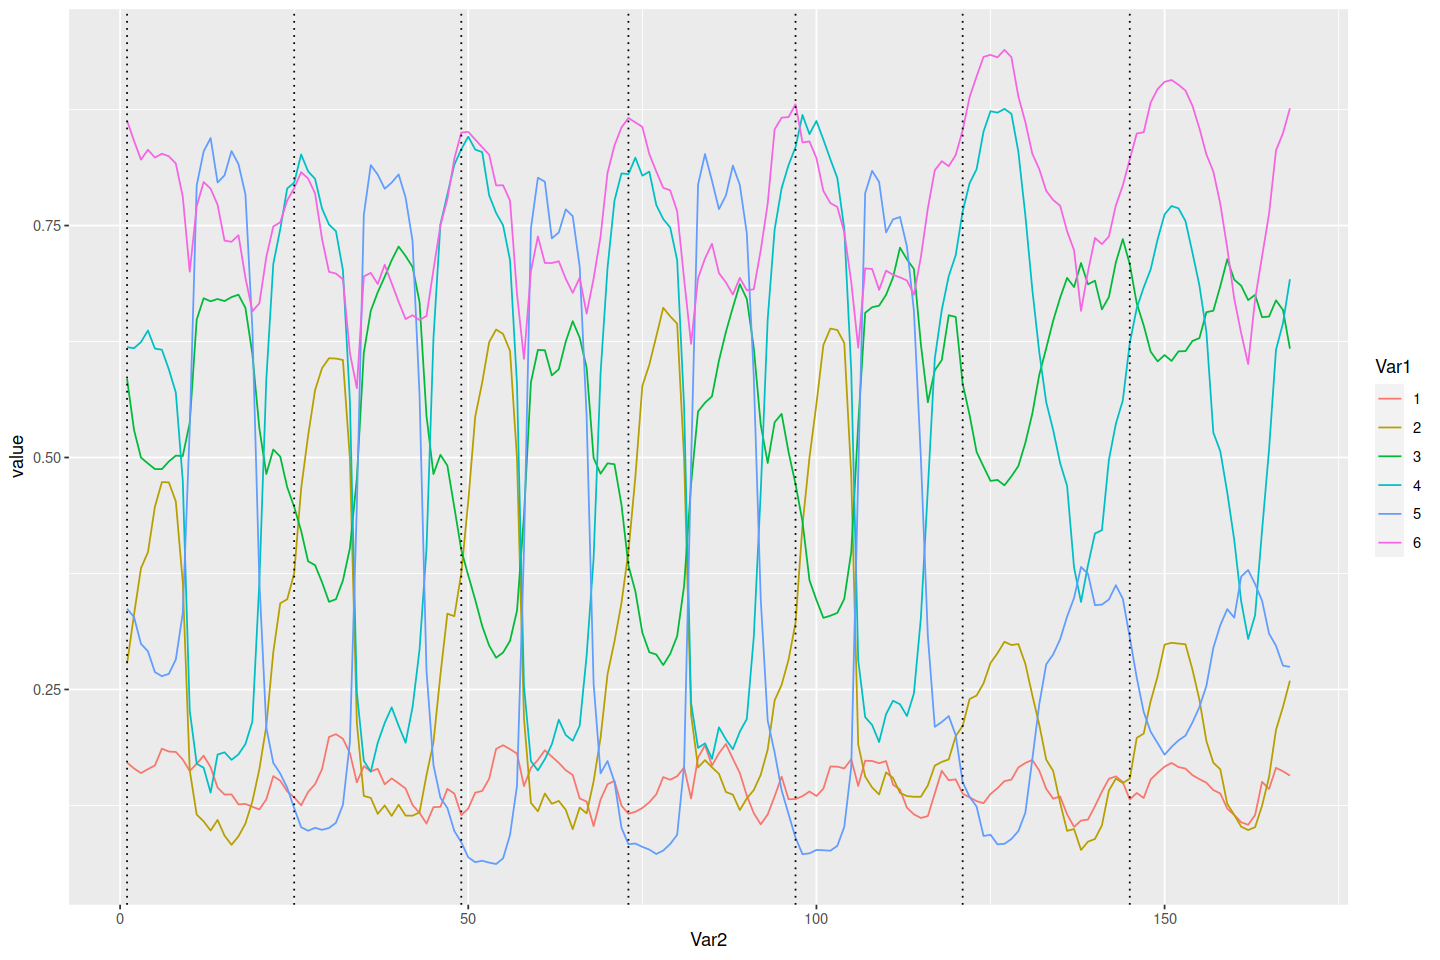

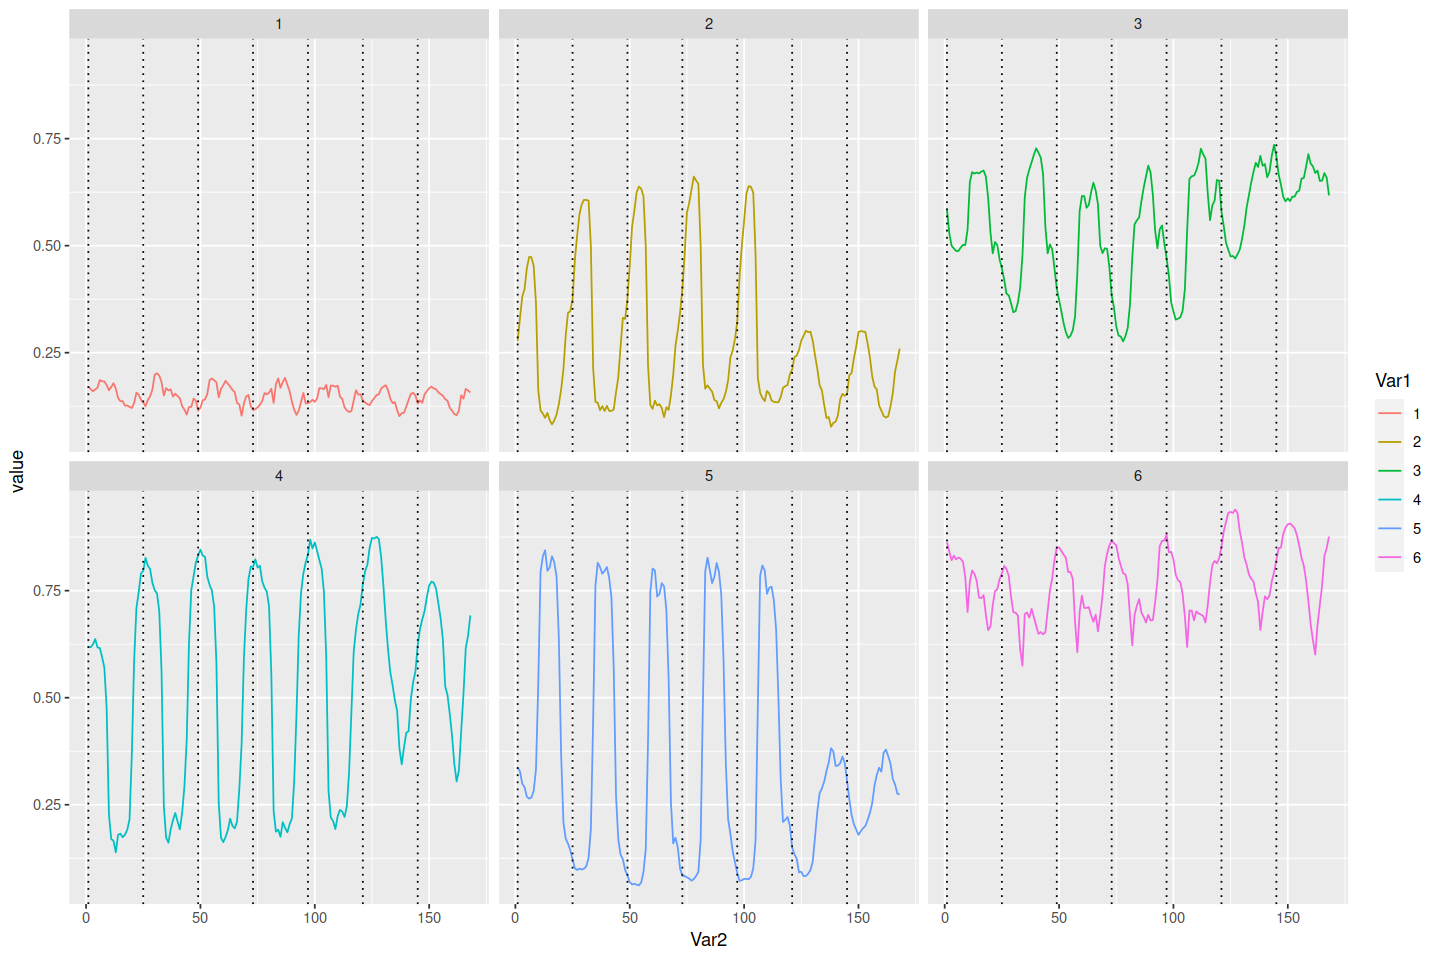

In [175]:
km = kmeans(x, centers = 6)
n_class = length(km$size)
color = rainbow(n_class)
# plot(km$center[1,], type = "l", col = color[1], ylim = c(0,1))
# abline(v = timeTick, lty = "dotted")
# for (i in 2:n_class) {
#     lines(km$center[i,], col = color[i])
# }
# legend("topleft", legend = paste("Class",seq(1,n_class)), col = color, lty = 1, ncol = 3)

# par(mfrow=c(2,3))
# for (i in 1:n_class) {
#     plot(km$center[i,], type = "l", col = color[i], main = paste("Class",i), ylim = c(0,1))
#     abline(v = timeTick, lty = "dotted")
# }
centers_long = melt(km$center)
centers_long$Var1 = as.factor(centers_long$Var1)
ggplot(data = centers_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_line() + geom_vline(xintercept = timeTick, linetype="dotted")
ggplot(data = centers_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_line() + facet_wrap(~Var1) + geom_vline(xintercept = timeTick, linetype="dotted")

***a.*** *Le centre de chaque classe représente la courbe d'occupation minimisant l'inertie dans la classe, i.e. la courbe la plus proche au sens des moindres carrés de toutes les autres courbes de la classe.*

*La classe 1 (en rouge) représente une classe de station très utilisées en milieu de journée la semaine, et très peu la nuit et le weekend.*

*La classe 5 (en bleu foncé) représente des stations très utilisées la nuit, et assez peu en journée.*

***b.*** *L'algorithme des k-means cherche à minimiser l'inertie intra-classe. Le minimum trouvé est local.*

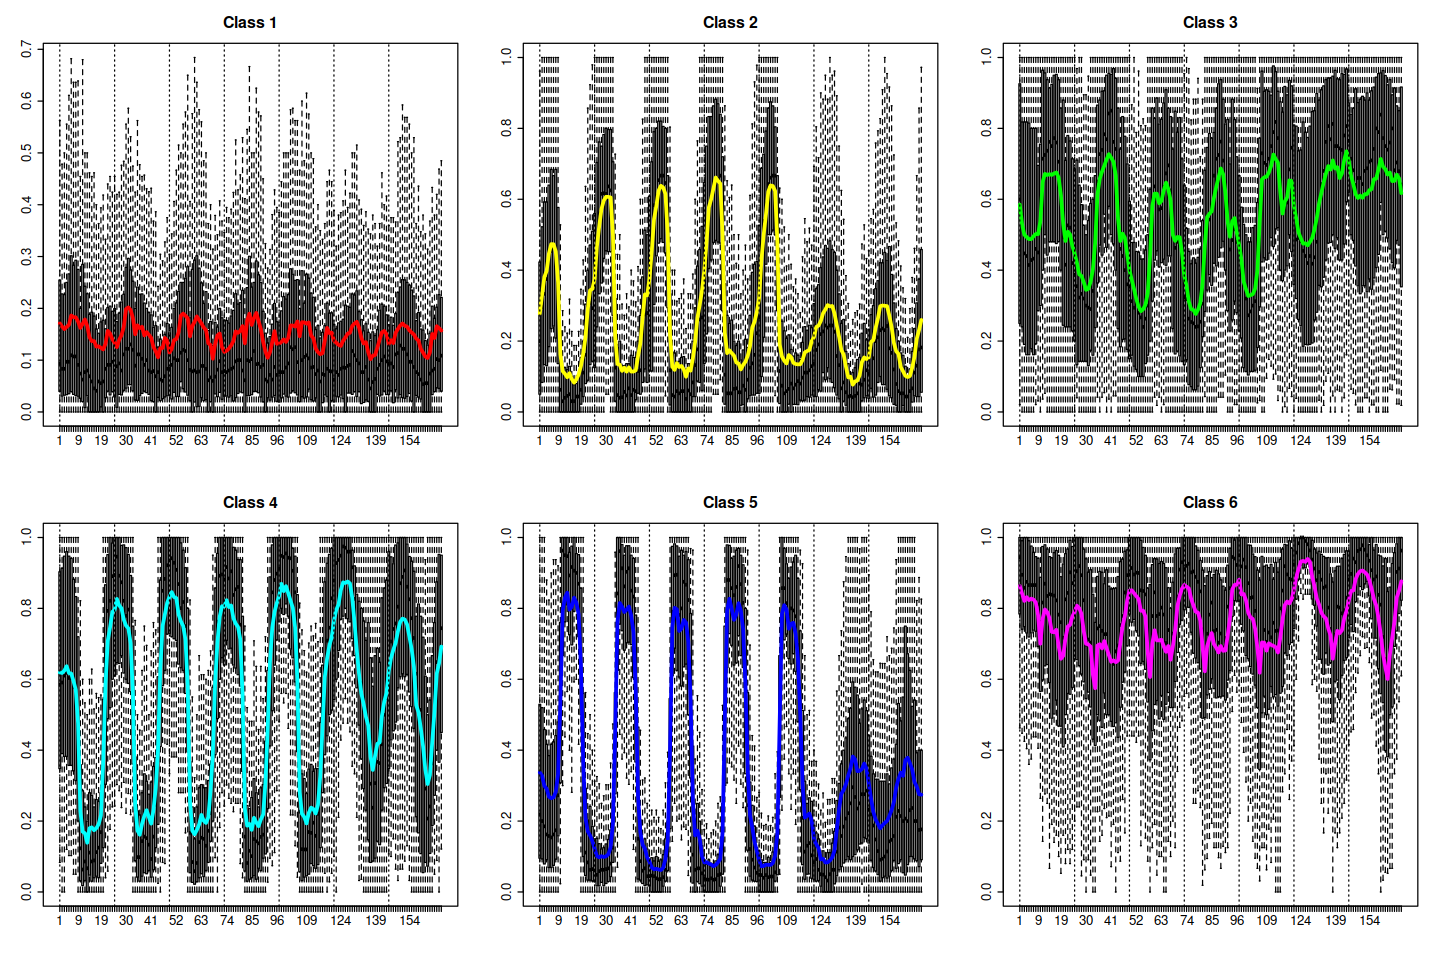

In [176]:
par(mfrow=c(2,3))
for (i in 1:n_class) {
    boxplot(x[which(km$cluster == i),], main = paste("Class",i), outline = FALSE)
    lines(km$center[i,], col = color[i], lwd = 3)
    abline(v = timeTick, lty = "dotted")
}
# x$class = km$cluster
# cluster_long = melt(x)
# cluster_long
#cluster_long$Var1 = as.factor(cluster_long$Var1)
#ggplot(data = cluster_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_boxplot() + facet_wrap(~Var1)# + geom_vline(xintercept = timeTick, linetype="dotted")

In [177]:
km$cluster

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  1   1   5   1   4   4   3   3   1   1   3   1   1   5   4   4   2   5   4   3 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
  1   4   1   5   2   2   1   6   5   4   5   3   5   5   5   1   3   1   5   3 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  5   5   6   2   3   6   6   4   4   3   3   3   3   5   3   5   3   2   2   3 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
  6   6   6   6   1   6   6   1   1   6   4   2   2   6   5   6   2   1   3   4 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  2   6   2   6   3   1   4   2   1   6   5   6   1   2   2   1   2   2   1   2 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
  2   4   3   3   1   4   1   1   1   1   3   2   4   5   1   2   1   4   4   6 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
  4   2   1   2   4   1   2   1   1   2   6   5   3   4   2   5   4   6   1   1 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
  1   5   2   1   1   2   1   6   2   4   6   4   4   2   6   4   3   6   2   2 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
  2   1   1   2   3   1   6   4   1   1   1   5   5   6   3   2   5   5   1   6 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
  6   5   1   2   1   1   4   1   4   1   2   1   1   6   2   6   6   6   2   4 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 
  3   1   1   6   1   4   3   2   1   4   3   6   3   4   1   6   4   5   1   5 
221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 
  3   5   3   5   5   1   3   3   1   2   1   1   1   6   5   4   1   6   1   2 
241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 
  2   4   5   4   1   1   4   2   5   2   2   3   3   3   5   5   3   2   1   5 
261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 
  4   1   1   6   2   4   5   4   3   3   5   5   1   2   6   2   6   5   5   1 
281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 
  2   1   1   6   2   3   2   4   5   1   3   5   4   2   2   5   6   3   5   1 
301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 
  3   6   4   4   2   6   1   5   1   5   3   6   5   2   1   1   2   5   2   4 
321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 
  2   1   4   5   4   5   2   5   6   3   2   4   5   2   1   6   1   1   4   1 
341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 
  1   2   1   2   3   2   1   2   1   6   3   1   2   2   4   1   2   5   1   5 
361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 
  1   1   1   5   4   4   1   1   2   1   4   3   1   5   6   2   1   5   1   5 
381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 
  3   1   5   6   3   5   5   1   6   3   3   1   3   2   3   2   1   1   2   4 
401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 
  2   1   1   4   3   2   4   3   2   6   1   1   5   2   2   1   1   2   4   6 
421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 
  2   3   2   5   2   4   5   4   5   2   1   4   4   1   5   1   4   1   1   1 
441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 
  5   4   1   3   1   3   2   4   1   2   4   3   6   1   1   6   1   2   6   5 
461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 
  1   5   1   1   6   2   1   5   4   1   3   2   5   6   5   3   1   2   2   2 
481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 
  5   4   2   1   2   5   1   4  

***c.*** *Les classes sont plutôt hommogènes. On observe une classe dont les stations sont souvent vides, et une donc les stations sont souvent chargées. Les autres classes ont une périodicité plus marquée.*

*Variance intra-classe faible, et variance inter-classe plus élevée.*

### Question 4. 

Plot the results on a map, using the station coordinates.
In practice, what is missing to interpret the results?

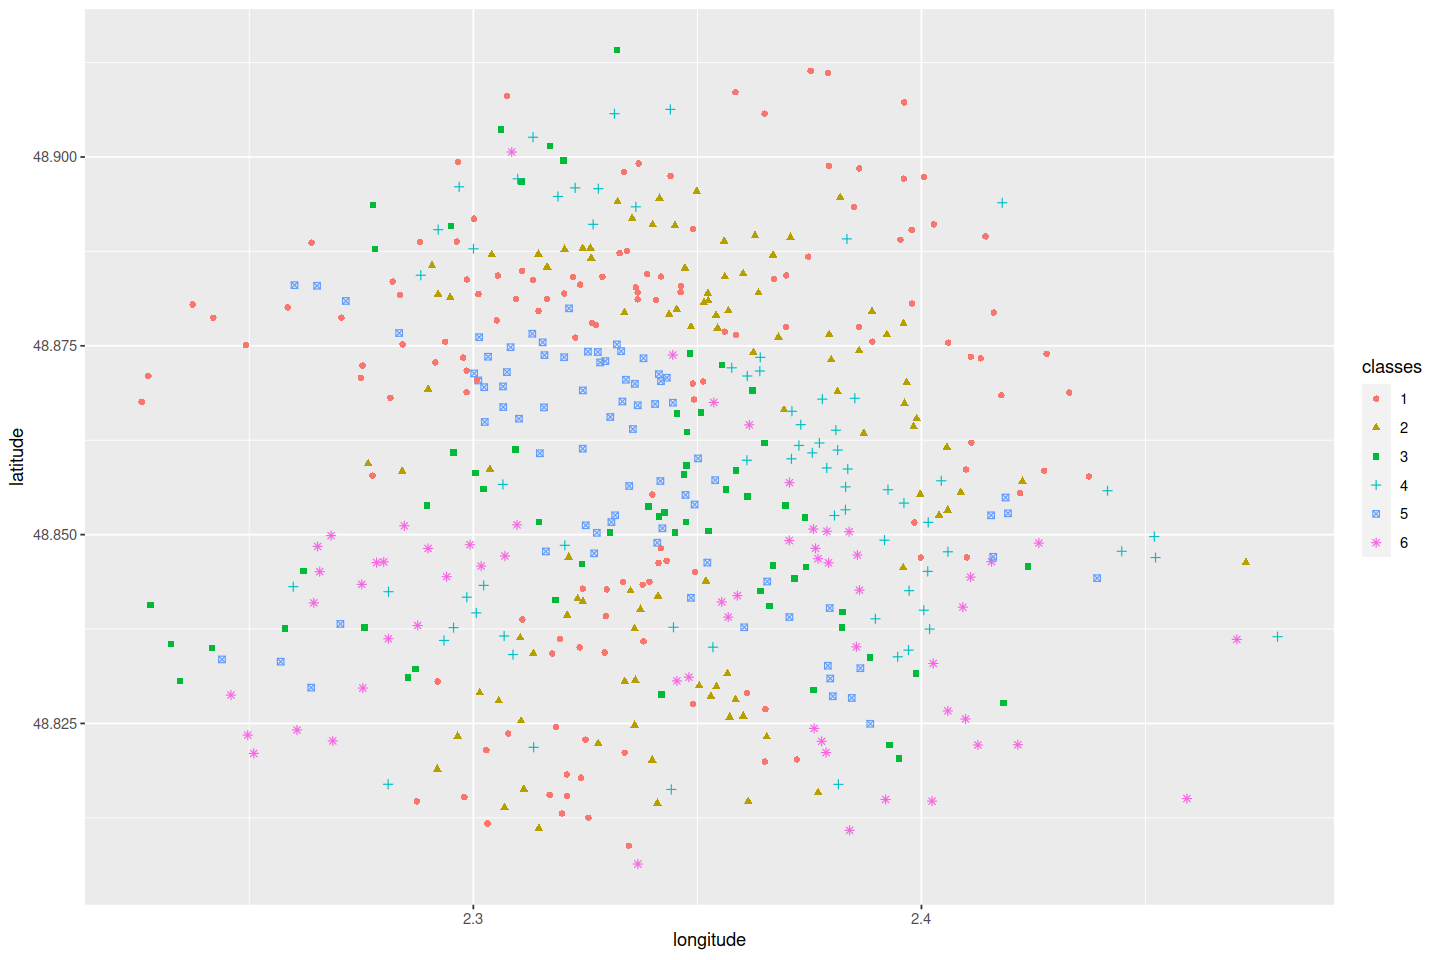

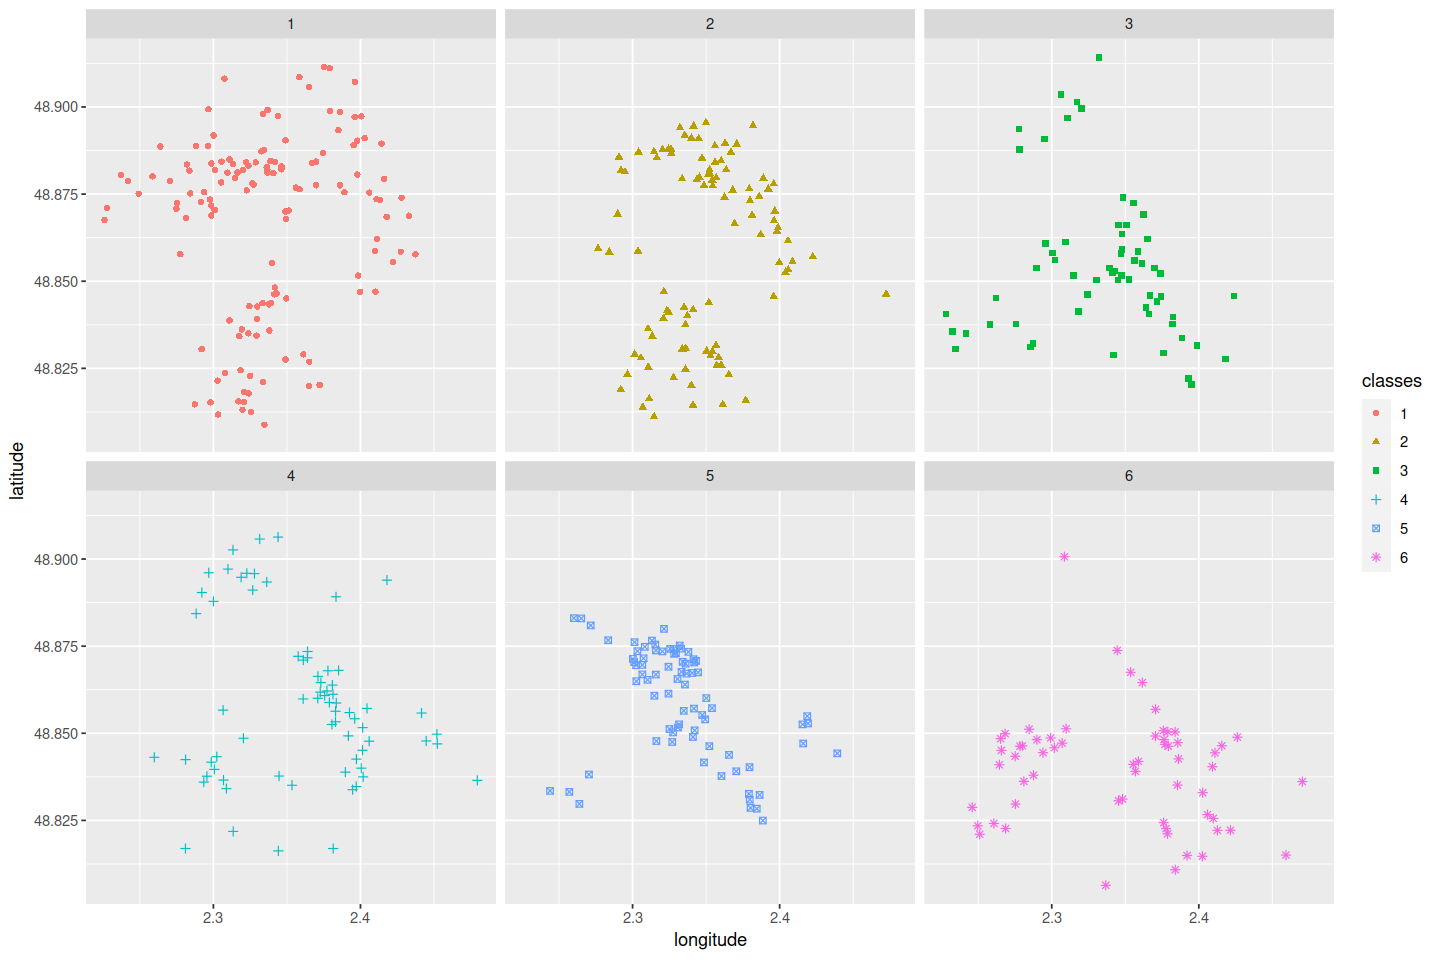

In [178]:
coord$classes = as.factor(km$cluster)
#plot(coord, col = km$cluster, pch = km$cluster)
#legend("topleft", legend = paste("Class",seq(1,n_class)), col = km$cluster, pch = km$cluster, ncol = 3)
ggplot(data = coord, mapping = aes(x = longitude, y = latitude, col = classes, shape = classes)) + geom_point()
ggplot(data = coord, mapping = aes(x = longitude, y = latitude, col = classes, shape = classes)) + geom_point() + facet_wrap(~classes)

In [179]:
paris = ggmap(get_stamenmap(rbind(as.numeric(paste(geocode_OSM("Paris")$bbox))), zoom = 14), darken = c(0.6, "white"))

84 tiles needed, this may take a while (try a smaller zoom).



Pour interpréter correctement les données, il nous faudrait ajouter une carte de Paris en dessous des points.

Warning message:
“Removed 31 rows containing missing values (geom_point).”
Warning message:
“Removed 31 rows containing missing values (geom_point).”


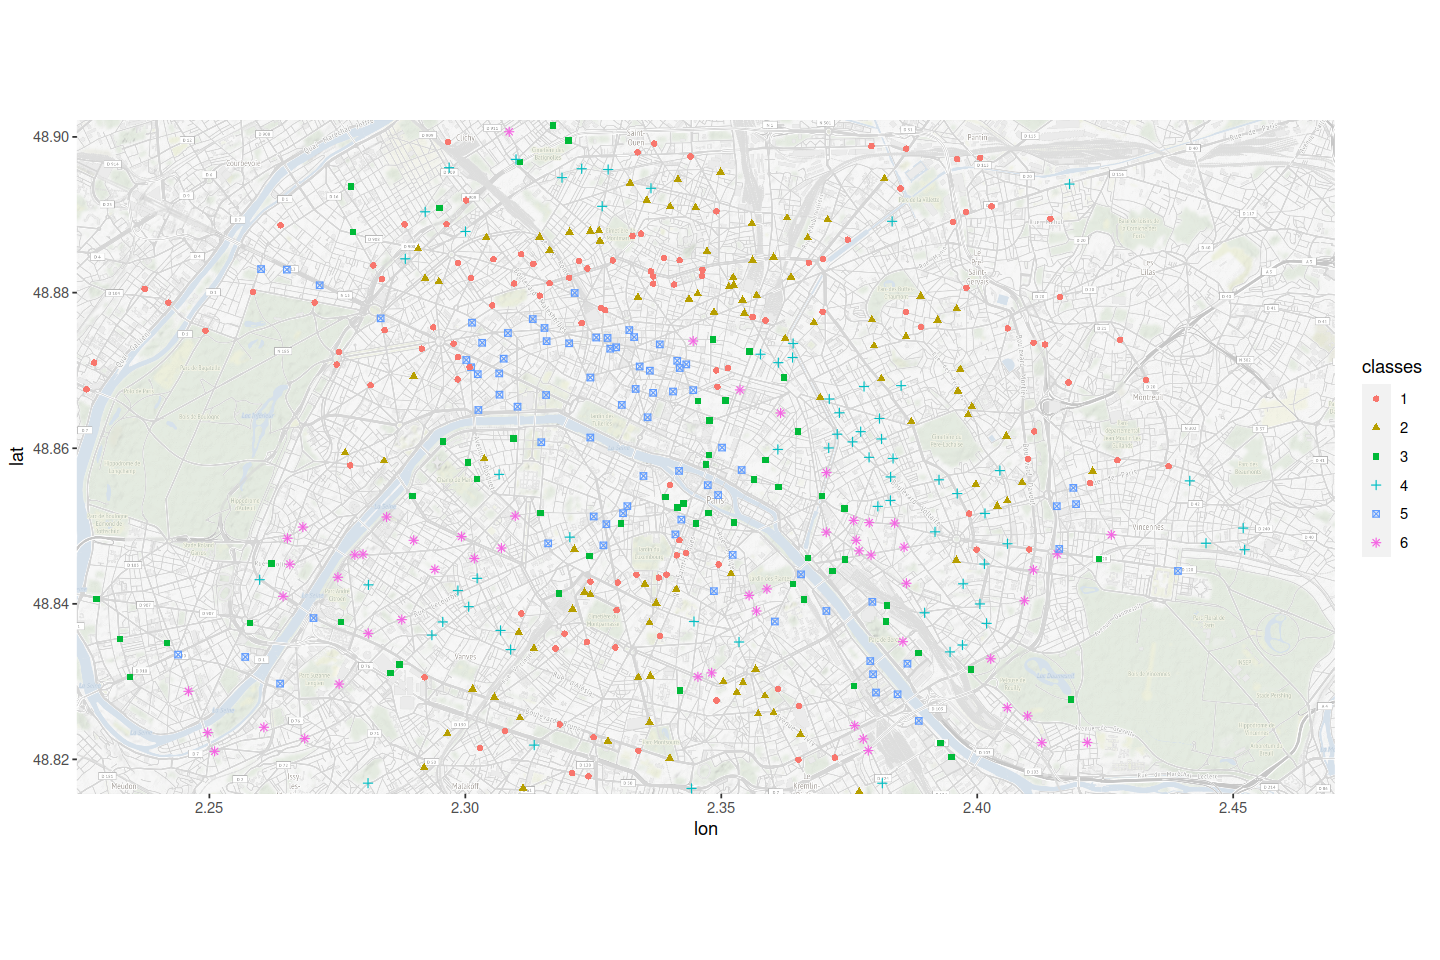

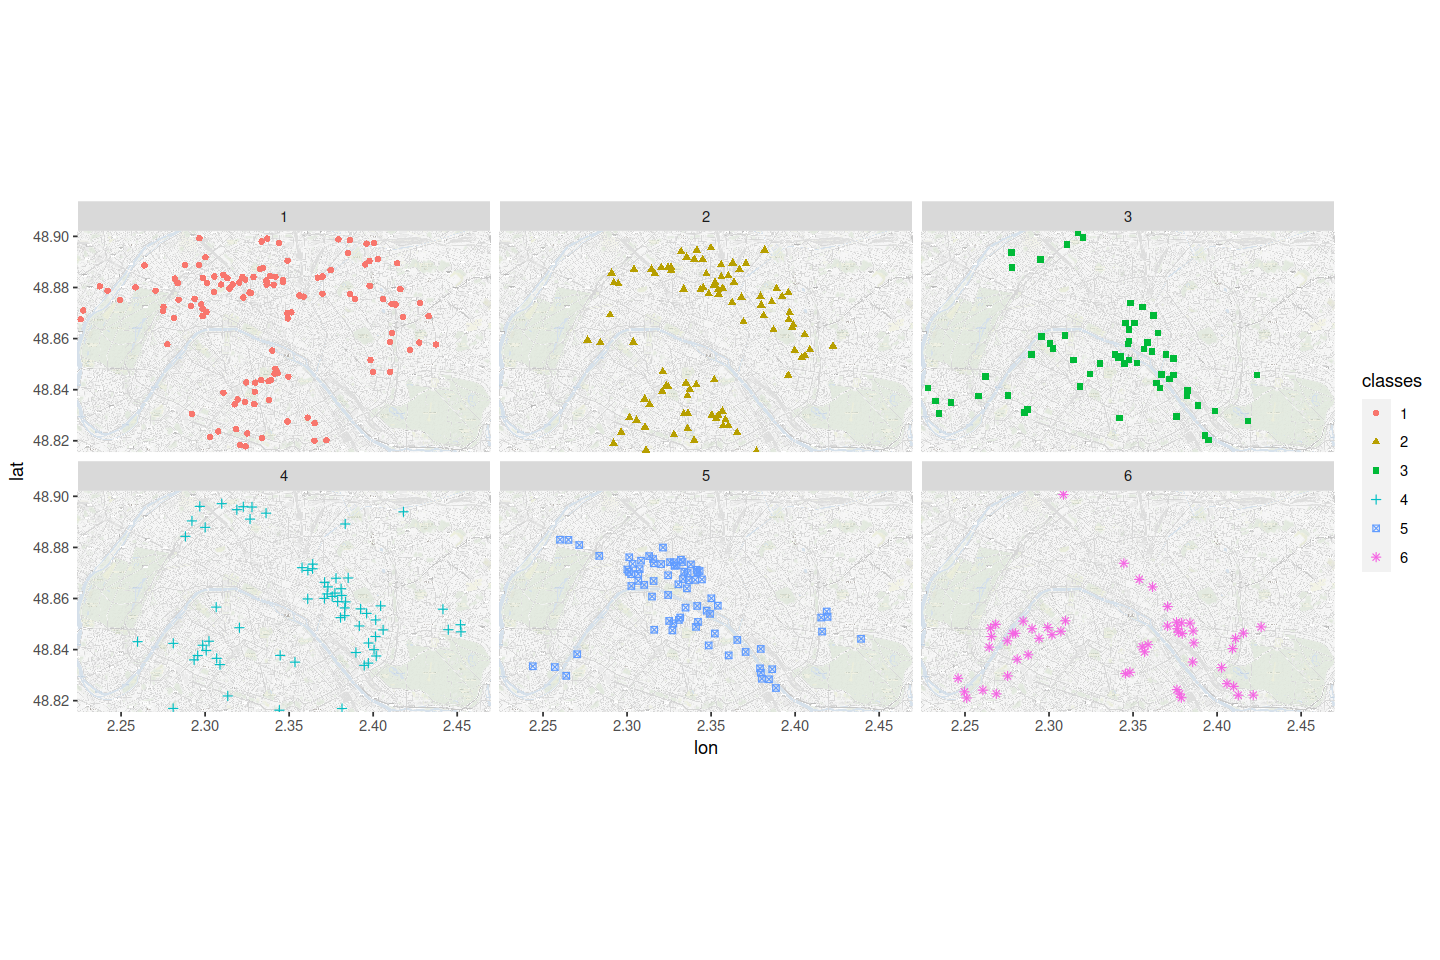

In [180]:
paris + geom_point(data = coord, aes(x = longitude, y = latitude, col = classes, shape = classes))
paris + geom_point(data = coord, aes(x = longitude, y = latitude, col = classes, shape = classes)) + facet_wrap(~classes)

### Question 5
Ready to go further? Now we consider all the data (not a subsample).
We need to reduce dimension, by approximating the functions in a Fourier basis (for instance). Then redo questions 1-4 by doing clustering on the coefficients of the Fourier basis. 

Help: First run the example of function funFEM.

In [216]:
help("funFEM")
help("smooth.basis")
help("basisfd")

*On va supposer le chargement avec une période de 7 jours. Pour avoir une précision journalière, on veut avoir au moins 7 oscillations dans notre semaine. On a donc 7 sinus, 7 cosinus et une constante, ce qui nous donne 15 fonctions dans notre base. Pour plus de précision, on peut prendre $\small 4 \times 7+1=29$ fonctions.*

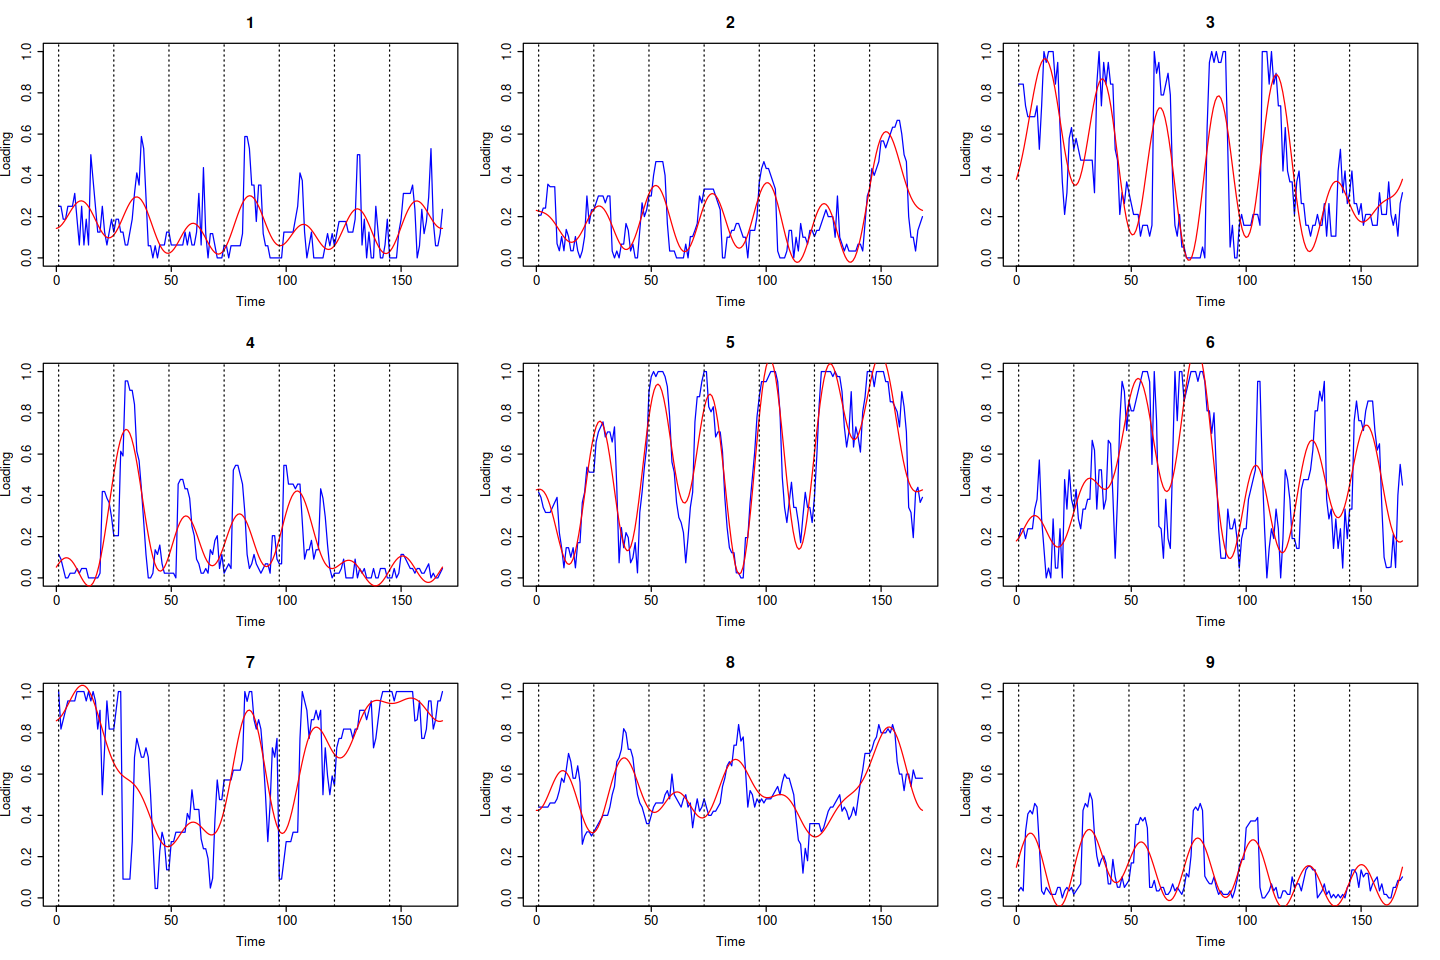

In [233]:
basis = create.fourier.basis(c(0,168), nbasis = 15)
fdobj <- smooth.basis(1:168,t(x),basis)$fd
par(mfrow = c(3, 3))
for (i in 1:9){
  plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = rownames(x)[i])
    lines(fdobj[i,], col = "red")
  abline(v = timeTick, lty = "dotted")
}

*À la place de faire notre clustering en dimensions 168, on va pouvoir le faire en dimension 15.*

In [258]:
# Clustrering with kmeans
res = kmeans(dist(fdobj$coefs), centers = 6)
res$centers[1,]
#res = funFEM(fdobj,K=6,model='AkjBk',init='kmeans',lambda=0,disp=TRUE)



# Visualization of group means
fdmeans = fdobj; fdmeans$cent = t(res$prms$my)
plot(fdmeans,col=1:res$K,xaxt='n',lwd=2)
axis(1,at=seq(5,181,6),labels=velib$dates[seq(5,181,6)],las=2)

const     sin1     cos1     sin2     cos2     sin3     cos3     sin4 
  0.0000 131.1419 126.2400 128.0280 127.3815 127.6862 127.1280 127.3426 
    cos4     sin5     cos5     sin6     cos6     sin7     cos7 
126.7281 128.2336 128.0932 127.6018 129.5484 126.5875 127.2163

ERROR: Error in t.default(res$prms$my): l'argument n'est pas une matrice
